In [ ]:


# Import basic tools
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

# Tools for training and testing the model
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.inspection import permutation_importance

# Get the dataset
import kagglehub

# Set plot size
plt.rcParams['figure.figsize'] = (8, 5)

In [ ]:

# Download the Blur Dataset
print("Downloading data...")
path = kagglehub.dataset_download("kwentar/blur-dataset")
print("Data location:", path)

# Check if folders are there
sharp_path = os.path.join(path, "sharp")
motion_path = os.path.join(path, "motion_blurred")
defocus_path = os.path.join(path, "defocused_blurred")

for p in [sharp_path, motion_path, defocus_path]:
    if not os.path.exists(p):
        raise FileNotFoundError(f"Folder {p} is missing. Please check the folder names.")

Using Colab cache for faster access to the 'blur-dataset' dataset.
Data location: /kaggle/input/blur-dataset


In [ ]:


# Lists to save paths and labels
image_paths = []
labels = []
blur_types = []

# Only take these file types
allowed_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif')

# Function to get image files from a folder
def get_image_files(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(allowed_extensions)]

# Grab sharp images -> Label 0
for file in get_image_files(sharp_path):
    image_paths.append(os.path.join(sharp_path, file))
    labels.append(0)
    blur_types.append('sharp')

# Grab motion blur images -> Label 1
for file in get_image_files(motion_path):
    image_paths.append(os.path.join(motion_path, file))
    labels.append(1)
    blur_types.append('motion')

# Grab defocused blur images -> Label 1
for file in get_image_files(defocus_path):
    image_paths.append(os.path.join(defocus_path, file))
    labels.append(1)
    blur_types.append('defocus')

# Put everything in a table
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels,
    'blur_type': blur_types
})

print(f"Done! Found {df.shape[0]} images.")
print("Check the labels:")
print(df['label'].value_counts())
print(df['blur_type'].value_counts())

Done! Found 1050 images.
Check the labels:
label
1    700
0    350
Name: count, dtype: int64
blur_type
sharp      350
motion     350
defocus    350
Name: count, dtype: int64


In [ ]:


def extract_features(image_path):
    """
    Get blur details from a grayscale image.

    What we get:
    - Laplacian: finds sharp changes.
    - Sobel X: finds horizontal changes.
    - Sobel Magnitude: average edge strength.
    - Tenengrad: squared edge strength.
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Warning: Couldn't read {image_path}")
        return None

    # 1. Laplacian variance
    laplacian = cv2.Laplacian(img, cv2.CV_64F)
    laplacian_var = laplacian.var()

    # 2. Sobel X and Sobel Y
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    # Sobel X variance (good for horizontal blur)
    sobel_x_var = sobel_x.var()

    # Sobel magnitude (how strong the edges are)
    sobel_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_mag_mean = sobel_magnitude.mean()

    # Tenengrad (average of squared magnitude)
    tenengrad_mean = (sobel_x**2 + sobel_y**2).mean()

    return laplacian_var, sobel_x_var, sobel_mag_mean, tenengrad_mean

In [ ]:


# Create empty lists to hold our data
laplacian_list = []
sobel_x_var_list = []
sobel_mag_mean_list = []
tenengrad_list = []
failed_images = []

# Loop through all images and get features
for img_path in df['image_path']:
    features = extract_features(img_path)
    if features is not None:
        lap, sx_var, mag_mean, tene = features
        laplacian_list.append(lap)
        sobel_x_var_list.append(sx_var)
        sobel_mag_mean_list.append(mag_mean)
        tenengrad_list.append(tene)
    else:
        # If something goes wrong, use 0 and keep track of the file
        laplacian_list.append(0.0)
        sobel_x_var_list.append(0.0)
        sobel_mag_mean_list.append(0.0)
        tenengrad_list.append(0.0)
        failed_images.append(img_path)

# Add these lists as new columns to our table
df['laplacian'] = laplacian_list
df['sobel_x_var'] = sobel_x_var_list
df['sobel_mag_mean'] = sobel_mag_mean_list
df['tenengrad'] = tenengrad_list

print("Features extracted successfully!")
if failed_images:
    print(f"Number of images that failed: {len(failed_images)}")
    print("A few examples:", failed_images[:3])

# Show the first 5 rows
df.head()

Features extracted successfully!


,image_path,label,blur_type,laplacian,sobel_x_var,sobel_mag_mean,tenengrad
0,/kaggle/input/blur-dataset/sharp/186_HONOR-8_S...,0,sharp,303.262079,649.859281,32.625635,2491.120179
1,/kaggle/input/blur-dataset/sharp/125_NIKON-D34...,0,sharp,4692.356157,2294.104645,36.213098,2884.914597
2,/kaggle/input/blur-dataset/sharp/155_HONOR-10_...,0,sharp,739.631595,2997.337909,31.606661,6641.108629
3,/kaggle/input/blur-dataset/sharp/299_NIKON-D34...,0,sharp,1633.610618,4987.821279,37.086573,9758.703626
4,/kaggle/input/blur-dataset/sharp/32_HUAWEI-P-S...,0,sharp,200.937266,1571.166775,22.237266,2590.039721


In [ ]:

# Choose which features to use
feature_columns = ['laplacian', 'sobel_x_var', 'sobel_mag_mean', 'tenengrad']
X = df[feature_columns].values
y = df['label'].values

print(f"Features array shape: {X.shape}")
print(f"Labels array shape: {y.shape}")

Features array shape: (1050, 4)
Labels array shape: (1050,)


In [ ]:

# Split the data but keep the balance between classes
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 840
Testing samples: 210


In [ ]:

# Setup the scaler and the model together
pipeline_20 = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(20,), max_iter=2000, random_state=42))
])

# Run the training
pipeline_20.fit(X_train, y_train)

# Get predictions and check the score
y_pred_20 = pipeline_20.predict(X_test)
acc_20 = accuracy_score(y_test, y_pred_20)

print(f"Model accuracy (20 nodes): {acc_20:.4f}")
print("\nFinal Report:")
print(classification_report(y_test, y_pred_20, target_names=['Sharp', 'Blurred']))

Model accuracy (20 nodes): 0.8905

Final Report:
              precision    recall  f1-score   support

       Sharp       0.90      0.76      0.82        70
     Blurred       0.89      0.96      0.92       140

    accuracy                           0.89       210
   macro avg       0.89      0.86      0.87       210
weighted avg       0.89      0.89      0.89       210



In [ ]:

# List of layer sizes to try
neuron_options = [10, 20, 50, 100]

neuron_results = []

for n in neuron_options:
    # Setup the scaler and the model together
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('mlp', MLPClassifier(hidden_layer_sizes=(n,), max_iter=2000, random_state=42))
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Evaluate the model
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    neuron_results.append((n, acc))

    print(f"Nodes: {n} -> Accuracy: {acc:.4f}")

# Find the best number of neurons
best_neurons, best_acc = max(neuron_results, key=lambda x: x[1])

print(f"\nBest number of nodes: {best_neurons} with accuracy {best_acc:.4f}")

Nodes: 10 -> Accuracy: 0.8905
Nodes: 20 -> Accuracy: 0.8905
Nodes: 50 -> Accuracy: 0.9095
Nodes: 100 -> Accuracy: 0.9048

Best number of nodes: 50 with accuracy 0.9095


In [ ]:


# Setup the cross-validation (5 parts)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline using our best number of nodes
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(best_neurons,), max_iter=2000, random_state=42))
])

# Double-check the accuracy using cross-validation
cv_scores = cross_val_score(best_pipeline, X, y, cv=cv, scoring='accuracy')
print(f"Results for the 5 folds: {cv_scores.round(4)}")
print(f"Average score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

Results for the 5 folds: [0.9381 0.9143 0.9143 0.9238 0.919 ]
Average score: 0.9219 (+/- 0.0088)


Final model accuracy on test data: 0.9095


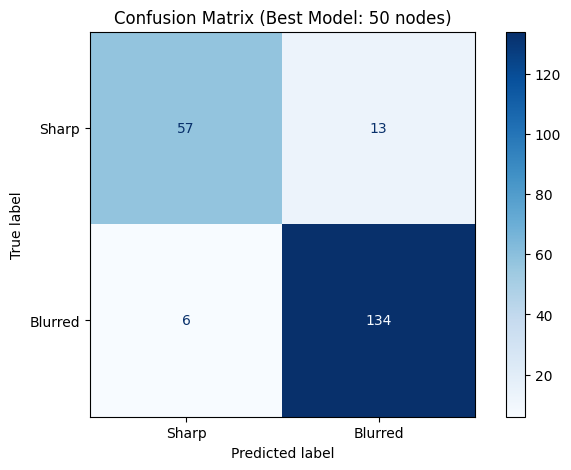

In [ ]:


# Train the final model
best_pipeline.fit(X_train, y_train)
y_pred_best = best_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Final model accuracy on test data: {test_accuracy:.4f}")

# Show where the model got confused
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sharp', 'Blurred'])
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix (Best Model: {best_neurons} nodes)')
plt.show()

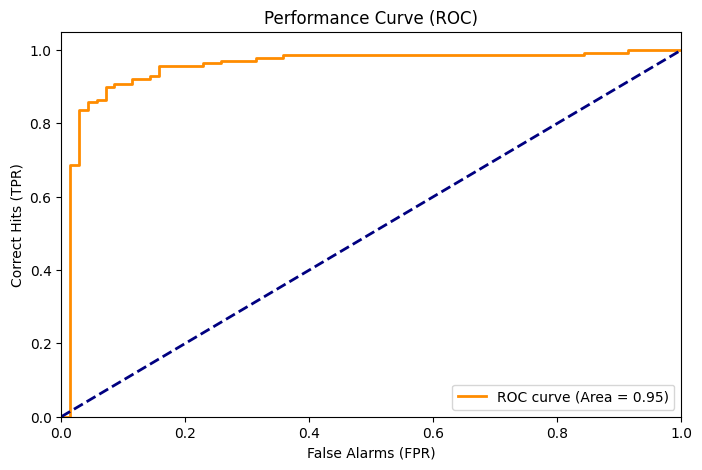

In [ ]:


# Get the confidence scores for the "Blurred" class
y_proba = best_pipeline.predict_proba(X_test)[:, 1]

# Calculate the ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the curve to see how well it separates classes
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Alarms (FPR)')
plt.ylabel('Correct Hits (TPR)')
plt.title('Performance Curve (ROC)')
plt.legend(loc="lower right")
plt.show()

          Feature  Importance       Std
1     sobel_x_var    0.200952  0.016050
3       tenengrad    0.170952  0.018862
2  sobel_mag_mean    0.027619  0.015765
0       laplacian    0.002857  0.009331


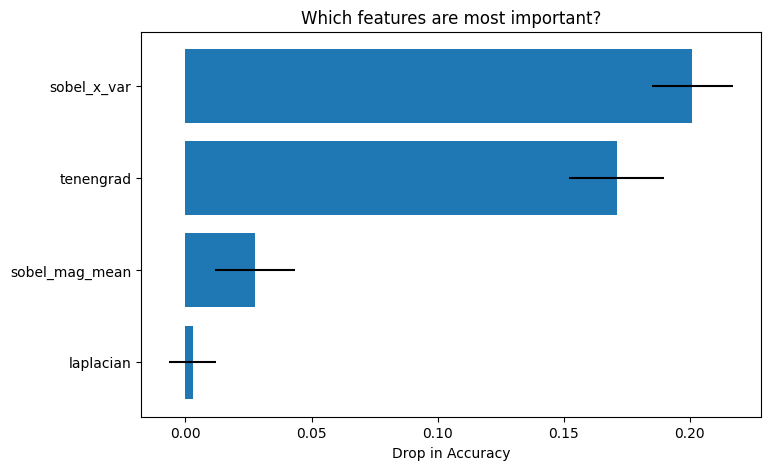

In [ ]:


# Find out which features matter most by shuffling them
perm_result = permutation_importance(
    best_pipeline, X_test, y_test,
    n_repeats=10, random_state=42, scoring='accuracy'
)

# Sort the features to see which one is the winner
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': perm_result.importances_mean,
    'Std': perm_result.importances_std
}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot the results
plt.figure()
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'])
plt.xlabel('Drop in Accuracy')
plt.title('Which features are most important?')
plt.gca().invert_yaxis()
plt.show()

In [ ]:


# Find the weakest feature (the last one in our list)
least_important_feature = importance_df.iloc[-1]['Feature']
print(f"The weakest feature is: {least_important_feature}")

# Remove it from our data
feature_columns_reduced = [f for f in feature_columns if f != least_important_feature]
print(f"Features we are keeping: {feature_columns_reduced}")

X_reduced = df[feature_columns_reduced].values
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Build a new pipeline with the same best settings
reduced_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(hidden_layer_sizes=(best_neurons,), max_iter=2000, random_state=42))
])

# Train and check the new model
reduced_pipeline.fit(X_train_red, y_train_red)
y_pred_red = reduced_pipeline.predict(X_test_red)
acc_red = accuracy_score(y_test_red, y_pred_red)

print(f"Accuracy after removing '{least_important_feature}': {acc_red:.4f}")
print("\nNew Report:")
print(classification_report(y_test_red, y_pred_red, target_names=['Sharp', 'Blurred']))

The weakest feature is: laplacian
Features we are keeping: ['sobel_x_var', 'sobel_mag_mean', 'tenengrad']
Accuracy after removing 'laplacian': 0.9095

New Report:
              precision    recall  f1-score   support

       Sharp       0.92      0.80      0.85        70
     Blurred       0.91      0.96      0.93       140

    accuracy                           0.91       210
   macro avg       0.91      0.88      0.89       210
weighted avg       0.91      0.91      0.91       210



In [ ]:


# Pick some images from the test set to check
demo_indices = [0, 10, 25, 50]

print("Let's see some predictions:\n")
for idx in demo_indices:
    if idx >= len(X_test_red):
        continue

    # Grab the features for this image
    features = X_test_red[idx].reshape(1, -1)
    true_label = y_test_red[idx]
    pred = reduced_pipeline.predict(features)[0]
    proba = reduced_pipeline.predict_proba(features)[0][1] # Chance it's blurred

    print(f"Sample #{idx}:")
    print(f"  - Real: {'Blurred' if true_label == 1 else 'Sharp'}")
    print(f"  - Predicted: {'Blurred' if pred == 1 else 'Sharp'}")
    print(f"  - Chance of blur: {proba:.3f}")
    print("  ---")

Let's see some predictions:

Sample #0:
  - Real: Sharp
  - Predicted: Sharp
  - Chance of blur: 0.034
  ---
Sample #10:
  - Real: Sharp
  - Predicted: Sharp
  - Chance of blur: 0.070
  ---
Sample #25:
  - Real: Blurred
  - Predicted: Blurred
  - Chance of blur: 0.975
  ---
Sample #50:
  - Real: Blurred
  - Predicted: Blurred
  - Chance of blur: 0.977
  ---


In [ ]:


import joblib

# Save the final model (the one with fewer features)
model_name = 'blur_detection_mlp.pkl'
joblib.dump(reduced_pipeline, model_name)
print(f"Model saved as: {model_name}")

# Save the list of features we used
with open('feature_columns.txt', 'w') as f:
    for col in feature_columns_reduced:
        f.write(col + '\n')
print("Feature list saved too!")

Model saved as: blur_detection_mlp.pkl
Feature list saved too!
